# Tutorial 7 - Lung cancer (Spatial CITE-seq)

In [1]:
import os
import torch
import scanpy as sc
import importlib
import numpy as np

In [2]:
from COSIE.data_preprocessing import load_data
from COSIE.utils import setup_seed
from COSIE.configure import get_default_config
from COSIE.COSIE_framework import COSIE_model
from COSIE.downstream_analysis import *

config = get_default_config()
setup_seed(config['training']['seed'])


## Load data

In [3]:
file_path = '../../../project/SpatialMultimodal/all_data/Lung_cancer'

In [4]:
adata1_rna = sc.read_h5ad(os.path.join(file_path, './P15_LUAD_Visium/adata_P15_LUAD_Visium_rna_istar.h5ad'))
adata1_adt = sc.read_h5ad(os.path.join(file_path, './P15_LUAD_Visium/adata_P15_LUAD_Visium_adt_istar.h5ad'))
adata2_rna = sc.read_h5ad(os.path.join(file_path, './P12_LUAD_Visium/adata_P12_LUAD_Visium_rna_istar.h5ad'))
adata2_adt = sc.read_h5ad(os.path.join(file_path, './P12_LUAD_Visium/adata_P12_LUAD_Visium_adt_istar.h5ad'))
adata3_rna = sc.read_h5ad(os.path.join(file_path, './P24_LUAD_Visium/adata_P24_LUAD_Visium_rna_istar.h5ad'))
adata3_adt = sc.read_h5ad(os.path.join(file_path, './P24_LUAD_Visium/adata_P24_LUAD_Visium_adt_istar.h5ad'))
adata4_rna = sc.read_h5ad(os.path.join(file_path, './P11_LUAD_Visium/adata_P11_LUAD_Visium_rna_istar.h5ad'))
adata4_adt = sc.read_h5ad(os.path.join(file_path, './P11_LUAD_Visium/adata_P11_LUAD_Visium_adt_istar.h5ad'))


adata1_rna, adata2_rna, adata3_rna, adata4_rna, adata1_adt, adata2_adt, adata3_adt, adata4_adt

(AnnData object with n_obs × n_vars = 1007874 × 3000
     obsm: 'UNI_feature', 'pxl_loc', 'spatial',
 AnnData object with n_obs × n_vars = 643444 × 3000
     obsm: 'UNI_feature', 'pxl_loc', 'spatial',
 AnnData object with n_obs × n_vars = 538057 × 3000
     obsm: 'UNI_feature', 'pxl_loc', 'spatial',
 AnnData object with n_obs × n_vars = 836958 × 3000
     obsm: 'UNI_feature', 'pxl_loc', 'spatial',
 AnnData object with n_obs × n_vars = 1007874 × 35
     obsm: 'UNI_feature', 'pxl_loc', 'spatial',
 AnnData object with n_obs × n_vars = 643444 × 35
     obsm: 'UNI_feature', 'pxl_loc', 'spatial',
 AnnData object with n_obs × n_vars = 538057 × 35
     obsm: 'UNI_feature', 'pxl_loc', 'spatial',
 AnnData object with n_obs × n_vars = 836958 × 35
     obsm: 'UNI_feature', 'pxl_loc', 'spatial')

In [5]:
adata1_rna.var_names_make_unique()
adata2_rna.var_names_make_unique()
adata3_rna.var_names_make_unique()
adata4_rna.var_names_make_unique()
adata1_adt.var_names_make_unique()
adata2_adt.var_names_make_unique()
adata3_adt.var_names_make_unique()
adata4_adt.var_names_make_unique()

In [6]:
adata1_he = sc.AnnData(X=adata1_adt.obsm['UNI_feature'])
adata2_he = sc.AnnData(X=adata2_adt.obsm['UNI_feature'])
adata3_he = sc.AnnData(X=adata3_adt.obsm['UNI_feature'])
adata4_he = sc.AnnData(X=adata4_adt.obsm['UNI_feature'])

adata1_he.obsm['spatial'] = adata1_adt.obsm['spatial'].copy()
adata2_he.obsm['spatial'] = adata2_adt.obsm['spatial'].copy()
adata3_he.obsm['spatial'] = adata3_adt.obsm['spatial'].copy()
adata4_he.obsm['spatial'] = adata4_adt.obsm['spatial'].copy()
adata1_he, adata2_he, adata3_he, adata4_he

(AnnData object with n_obs × n_vars = 1007874 × 2048
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 643444 × 2048
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 538057 × 2048
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 836958 × 2048
     obsm: 'spatial')

## Define the dictionary structure for input data

Each column denotes one section and None represents that the modality is missing in that section.

In [7]:
data_dict = {
        'HE': [adata1_he, adata2_he, adata3_he, adata4_he],
        'RNA': [adata1_rna, adata2_rna, None, None],
        'Protein': [None, None, adata3_adt, None],
    }

In [8]:
feature_dict, spatial_loc_dict, data_dict_processed = load_data(data_dict, n_comps=50, metacell = True)

Combine adjacent 4 cells into metacell to save memory and speed up computation
-------- Processing shared modality HE across sections --------
Running Harmony for HE


2025-05-19 18:30:40,741 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-19 18:31:19,858 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-19 18:31:26,661 - harmonypy - INFO - Iteration 1 of 10
2025-05-19 18:36:28,391 - harmonypy - INFO - Iteration 2 of 10
2025-05-19 18:40:58,613 - harmonypy - INFO - Converged after 2 iterations


-------- Processing shared modality RNA across sections --------
Running Harmony for RNA


2025-05-19 18:42:50,557 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-19 18:43:11,966 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-19 18:43:15,342 - harmonypy - INFO - Iteration 1 of 10
2025-05-19 18:45:44,009 - harmonypy - INFO - Iteration 2 of 10
2025-05-19 18:48:19,920 - harmonypy - INFO - Iteration 3 of 10
2025-05-19 18:50:56,576 - harmonypy - INFO - Iteration 4 of 10
2025-05-19 18:53:30,398 - harmonypy - INFO - Iteration 5 of 10
2025-05-19 18:56:06,477 - harmonypy - INFO - Iteration 6 of 10
2025-05-19 18:58:46,791 - harmonypy - INFO - Iteration 7 of 10
2025-05-19 19:01:23,975 - harmonypy - INFO - Iteration 8 of 10
2025-05-19 19:03:57,133 - harmonypy - INFO - Converged after 8 iterations


-------- Processing unique modality Protein for section 3 --------
Extracting spatial location for section 1
Extracting spatial location for section 2
Extracting spatial location for section 3
Extracting spatial location for section 4


## Specify the linkage indicator

COSIE requires a indicator dictionary to specify the cross-section linkage used during training.

For example, `('s1', 's2'): [('HE', 'HE'), ('RNA', 'RNA')]` means both HE-HE and RNA-RNA linkage will be utilized for integrate Section s1 and s2.

In [14]:

Linkage_indicator = {
        ('s1', 's2'): [('HE', 'HE'), ('RNA', 'RNA')],
        ('s1', 's3'): [('HE', 'HE'), ('RNA', 'Protein')],
        ('s1', 's4'): [('HE', 'HE')],
        ('s2', 's3'): [('HE', 'HE'), ('RNA', 'Protein')],
        ('s2', 's4'): [('HE', 'HE')],
        ('s3', 's4'): [('HE', 'HE')],
    }

## Define COSIE model and perform integration

After training, embeddings will be saved to `file_path` in `.npy` format.

In [15]:
model = COSIE_model(config, feature_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['lr'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

All modalities: ['HE', 'RNA', 'Protein']
-------- Encoder description --------
Encoder [HE]: Input 50 → Hidden [256, 128]
Encoder [RNA]: Input 50 → Hidden [256, 128]
Encoder [Protein]: Input 20 → Hidden [256, 128]
-------- Dual prediction module description --------
Predictor [HE → RNA]: [128, 512, 512, 128]
Predictor [RNA → HE]: [128, 512, 512, 128]
Predictor [HE → Protein]: [128, 512, 512, 128]
Predictor [Protein → HE]: [128, 512, 512, 128]
Using device: cuda:0


In [16]:
final_embeddings = model.train_model(file_path, config, optimizer, device, feature_dict, spatial_loc_dict, 
                                     data_dict_processed, Linkage_indicator, n_x=2, n_y=2)

-------- Running Sub-graph training mode, n_x is 2, n_y is 2 --------
Splitting section [s1] into 2 x 2 subgraphs
Splitting HE in section s1...
Splitting RNA in section s1...
Splitting section [s2] into 2 x 2 subgraphs
Splitting HE in section s2...
Splitting RNA in section s2...
Splitting section [s3] into 2 x 2 subgraphs
Splitting HE in section s3...
Splitting Protein in section s3...
Splitting section [s4] into 2 x 2 subgraphs
Splitting HE in section s4...
Computing linkage between [HE] (s1-0) and [HE] (s2-0)
Computing linkage between [RNA] (s1-0) and [RNA] (s2-0)
Computing linkage between [HE] (s1-0) and [HE] (s2-1)
Computing linkage between [RNA] (s1-0) and [RNA] (s2-1)
Computing linkage between [HE] (s1-0) and [HE] (s2-2)
Computing linkage between [RNA] (s1-0) and [RNA] (s2-2)
Computing linkage between [HE] (s1-0) and [HE] (s2-3)
Computing linkage between [RNA] (s1-0) and [RNA] (s2-3)
Computing linkage between [HE] (s1-1) and [HE] (s2-0)
Computing linkage between [RNA] (s1-1) and 

Training Epochs: 100%|████████████████████████████████████████████████████████████████| 600/600 [22:29<00:00,  2.25s/it]


 Running Evaluation...
Missing modality [Protein] in Section [s1]
Using predictor [HE → Protein] to recover missing embedding...
Mapping metacell embedding back to original cells for Section s1 using modality [HE]
Missing modality [Protein] in Section [s2]
Using predictor [HE → Protein] to recover missing embedding...
Mapping metacell embedding back to original cells for Section s2 using modality [HE]
Missing modality [RNA] in Section [s3]
Using predictor [HE → RNA] to recover missing embedding...
Mapping metacell embedding back to original cells for Section s3 using modality [HE]
Missing modality [RNA] in Section [s4]
Using predictor [HE → RNA] to recover missing embedding...
Missing modality [Protein] in Section [s4]
Using predictor [HE → Protein] to recover missing embedding...
Mapping metacell embedding back to original cells for Section s4 using modality [HE]
All embeddings have been saved to ../../../project/SpatialMultimodal/all_data/Lung_cancer


## Perform clustering and visualization

Perform joint clustering...
Saved: ./Figures/Lung_cancer/COSIE_section_s1.jpg


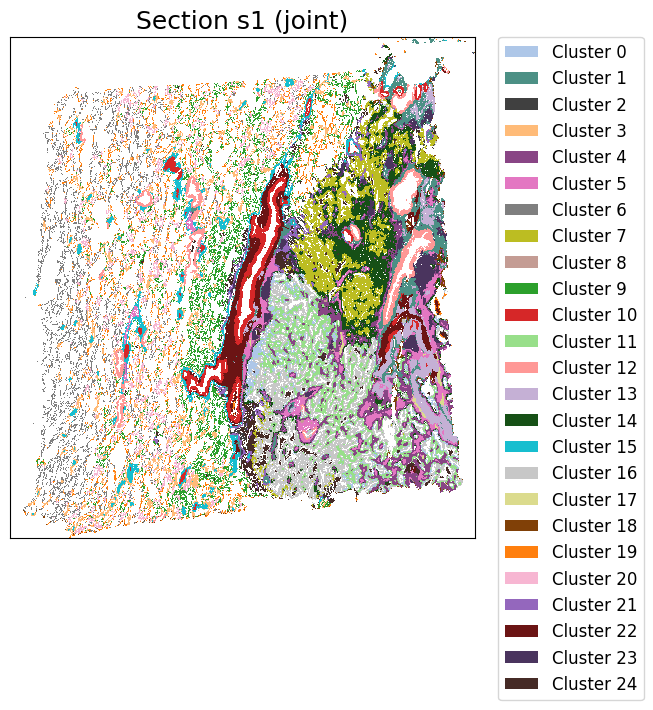

Saved: ./Figures/Lung_cancer/COSIE_section_s2.jpg


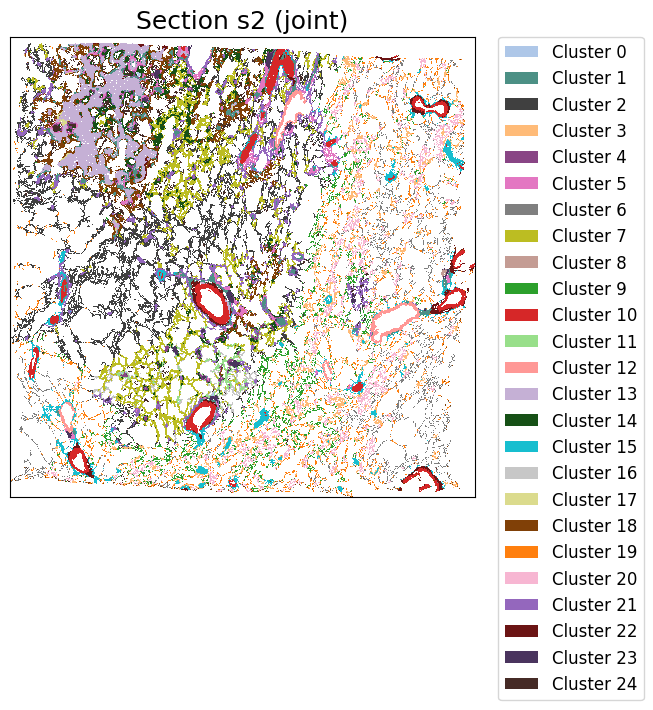

Saved: ./Figures/Lung_cancer/COSIE_section_s3.jpg


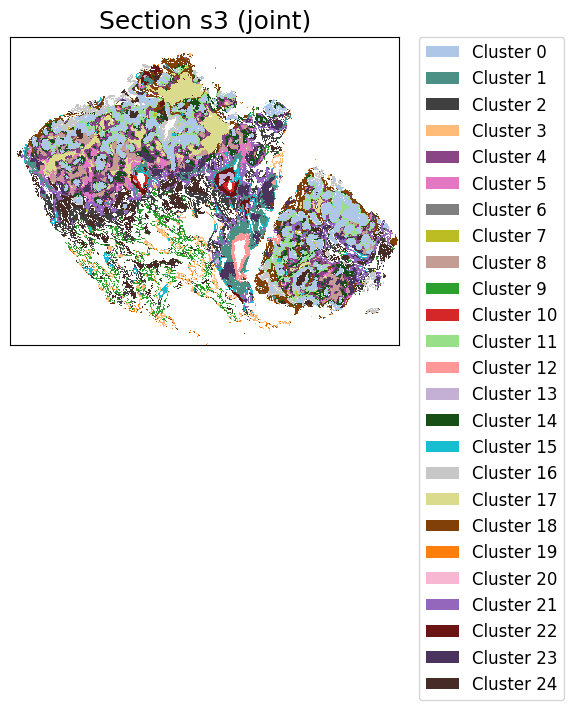

Saved: ./Figures/Lung_cancer/COSIE_section_s4.jpg


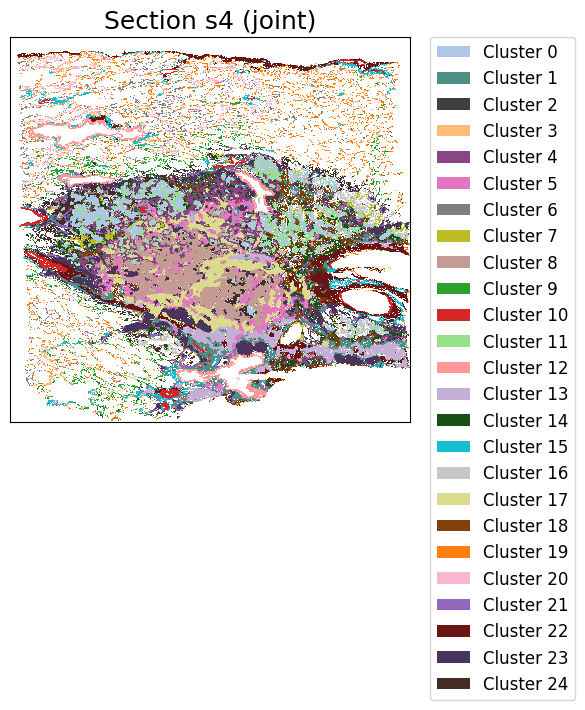

In [17]:
color_map = [[174,199,232],[76, 144, 133],[64,64,64],[255,187,120],
              [137, 69, 133],[227,119,194],[127,127,127],[188,189,34],
              [196,156,148],[44,160,44],[214,39,40],[152,223,138],
              [255,152,150],[197,176,213],[22,80,22],[23,190,207],
              [199,199,199],[219,219,141],[128,64,7],[255,127,14],
              [247,182,210],[148,103,189],
             [107,20,20],[74,52,94],[70,43,38],
              [114,60,97],[94,94,17],[12,95,104],[0,0,0]]

cluster_label = cluster_and_visualize_superpixel(final_embeddings, 
                                                 data_dict,
                                                 n_clusters=25,
                                                 mode="joint", 
                                                 vis_basis="spatial",  
                                                 colormap = color_map, 
                                                 save_path = './Figures/Lung_cancer/COSIE.jpg',
                                                 dpi = 500,
                                                 figscale = 220)

In [18]:
merge_groups = [[1, 13, 22], [10, 15]]   # Merge clusters
new_cluster_label = merge_clusters_to_new_ids(cluster_label, merge_groups)
sorted_cluster_label = relabel_clusters_sequentially(new_cluster_label)

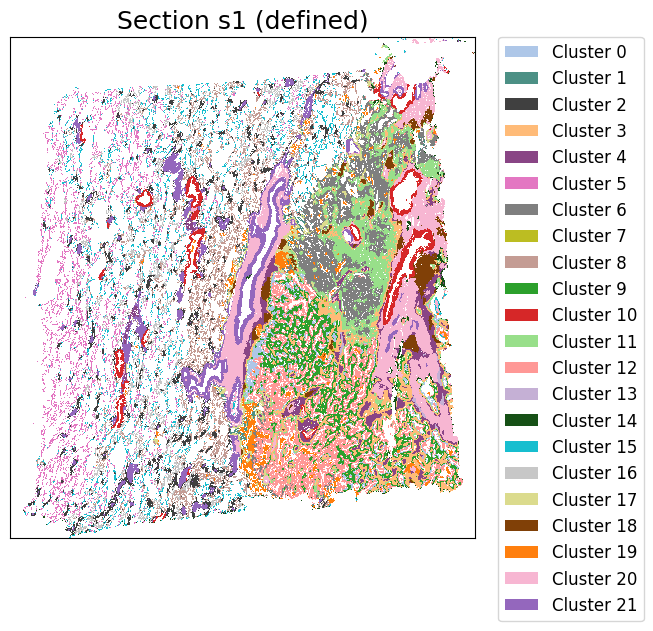

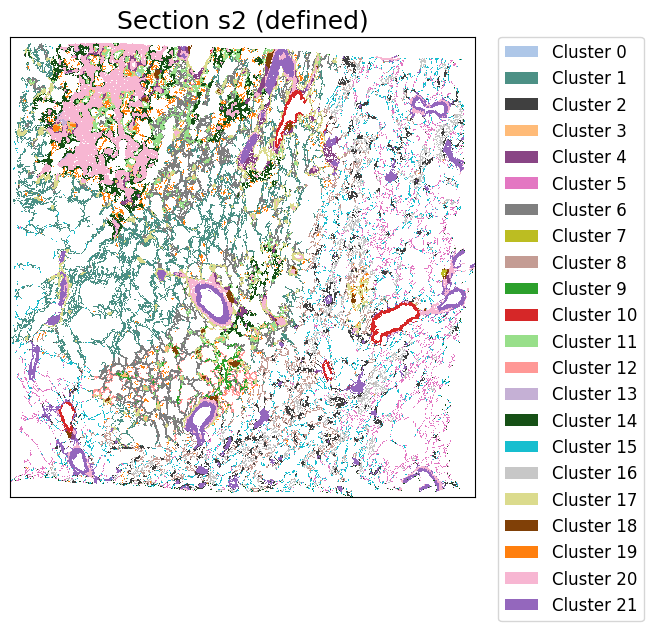

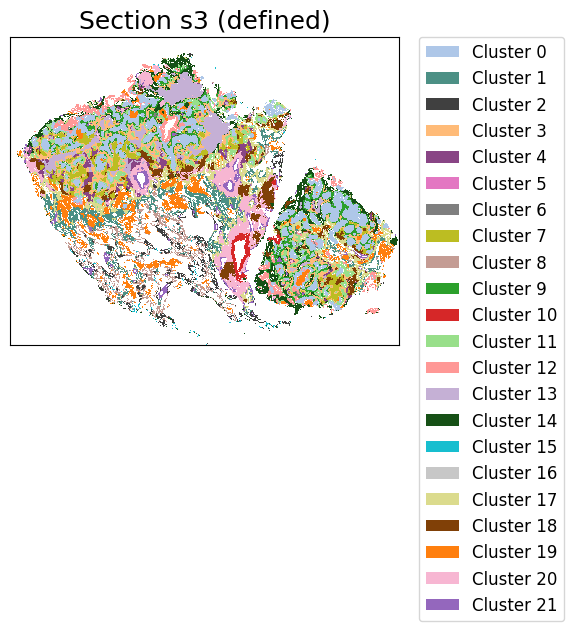

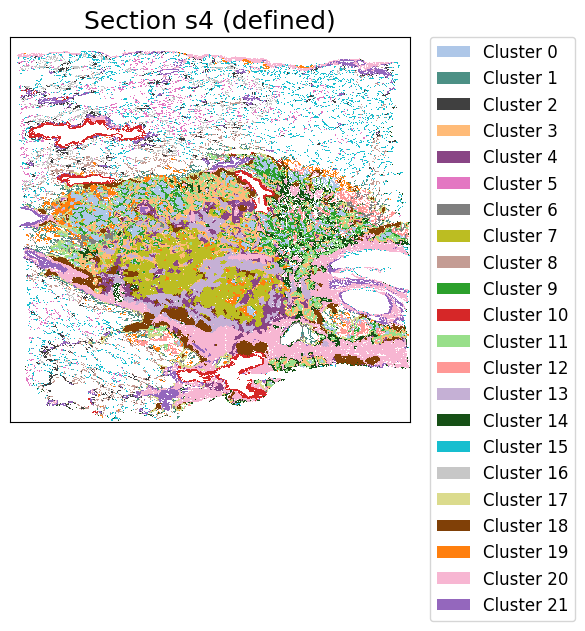

In [19]:
sorted_cluster_label_return = cluster_and_visualize_superpixel(final_embeddings, 
                                                 data_dict,
                                                 n_clusters=22,
                                                 mode="defined", 
                                                 defined_labels=sorted_cluster_label,
                                                 vis_basis="spatial",  
                                                 colormap = color_map, 
                                                 dpi = 500,
                                                 figscale = 220)

## Highlight target cluster for better visualization

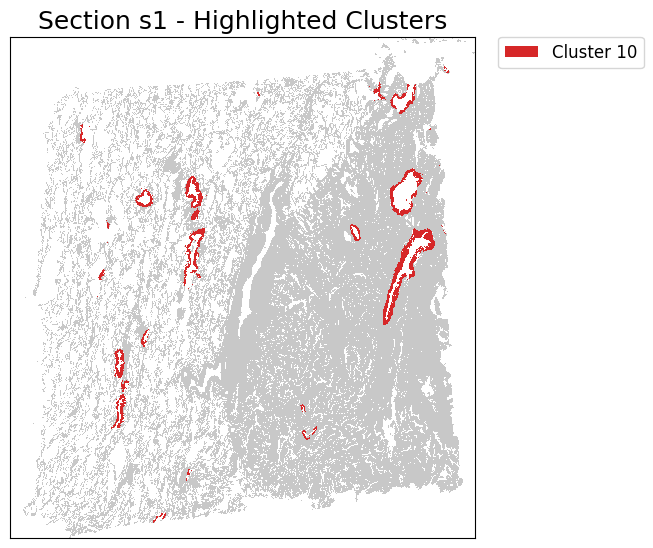

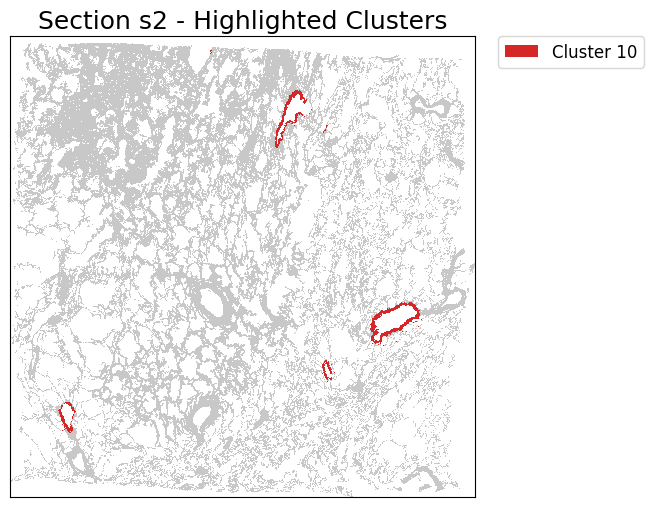

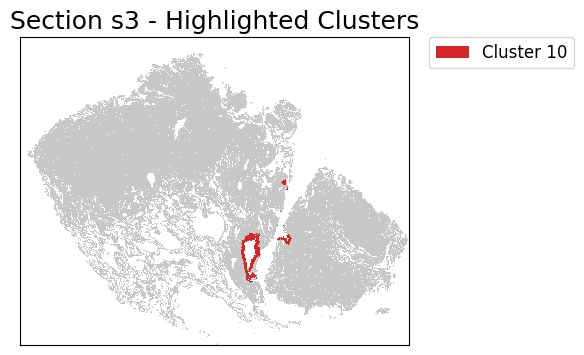

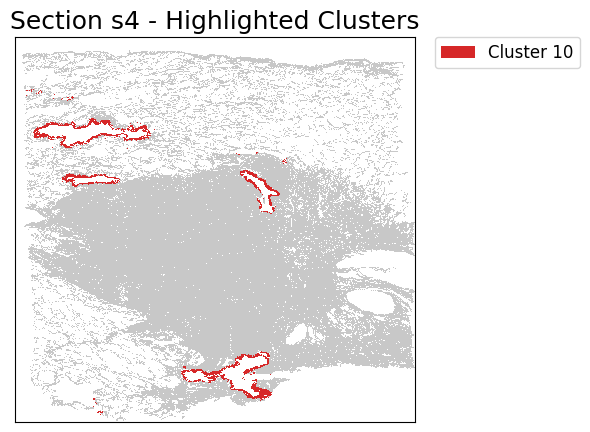

In [20]:
highlight_joint_clusters_all_sections(
    cluster_labels=sorted_cluster_label,
    data_dict=data_dict,
    n_clusters=22,
    highlight_labels=[10] ,
    vis_basis='spatial',
    colormap = color_map, 
    figscale=220,
    dpi=500,
    remove_title=False,
    remove_legend=False,
    remove_spine=False,
    bg_color = [200, 200, 200]
)

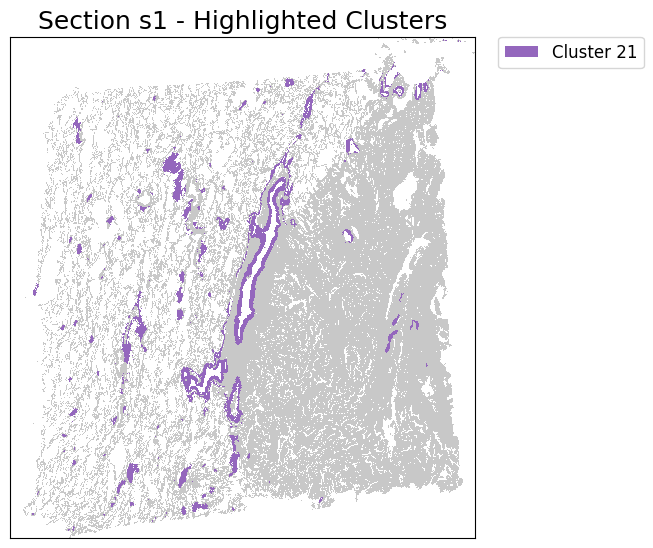

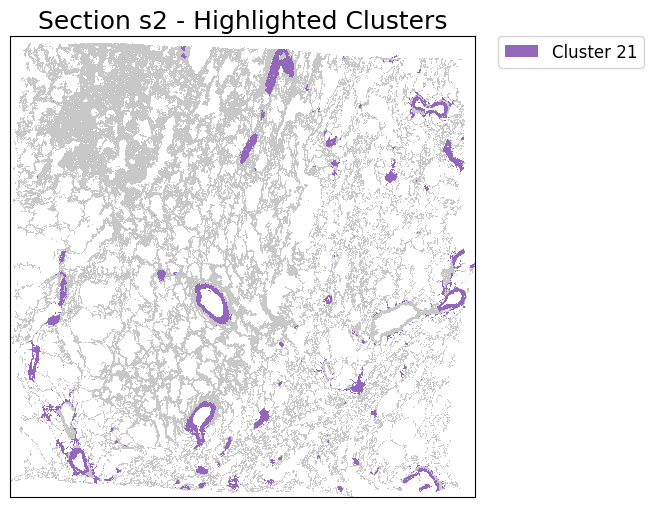

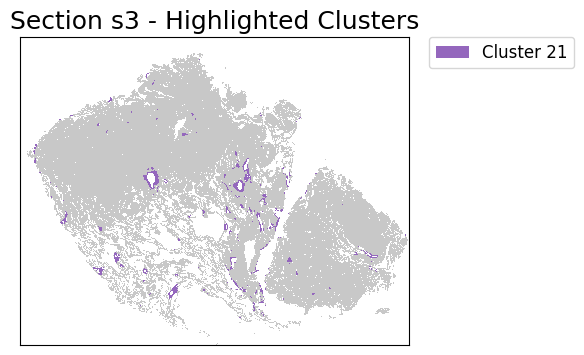

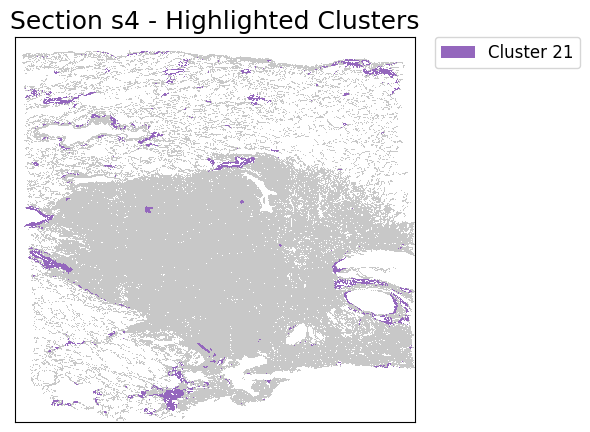

In [21]:
highlight_joint_clusters_all_sections(
    cluster_labels=sorted_cluster_label,
    data_dict=data_dict,
    n_clusters=22,
    highlight_labels=[21] ,
    vis_basis='spatial',
    colormap = color_map, 
    figscale=220,
    dpi=500,
    remove_title=False,
    remove_legend=False,
    remove_spine=False,
    bg_color = [200, 200, 200]
)

## Perform imputation

For Section 4, only the H&E image was available during training. We focused on this most challenging scenario.


##### Protein imputation

In [22]:
adata4_protein_imputed = perform_imputation(data_dict,
    final_embeddings,
    target_section = 's4',
    target_modality = 'Protein',
    K_num=500,
    target_molecules='All',
    )

Using modality [HE] in section [s4] as spatial/obs reference
[Protein] exists in ['s3'], which will be used as source data section


In [26]:
adata4_protein_imputed

AnnData object with n_obs × n_vars = 836958 × 35
    obsm: 'spatial'

In [28]:
adata4_protein_imputed_norm = create_normalized_adata(adata4_protein_imputed)
adata4_adt_norm = create_normalized_adata(adata4_adt)

Saving marker comparison to: ./Figures/Lung_cancer/s4_protein_PAX5.jpg


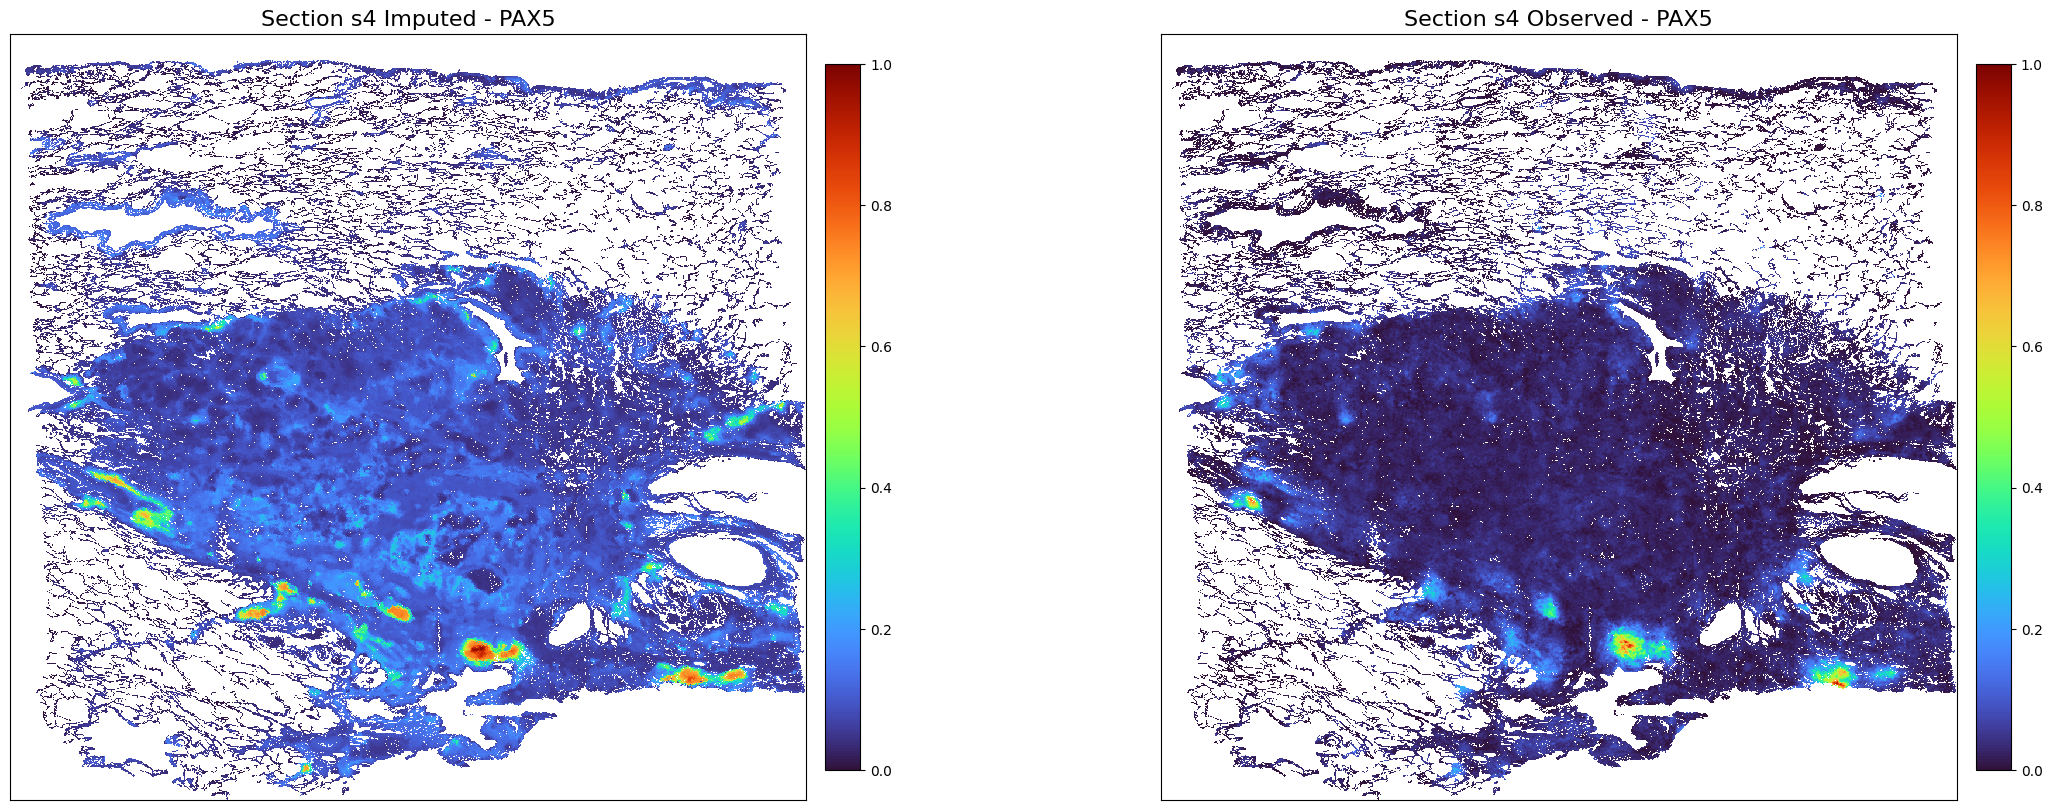

In [29]:
chosed_protein = 'PAX5'
plot_marker_comparison_superpixel(chosed_protein, 
                       adata4_protein_imputed_norm, 
                       adata4_adt_norm, 
                       'Section s4 Imputed', 
                       'Section s4 Observed',
                        figscale = 100,
                        save_path = './Figures/Lung_cancer/s4_protein_{}.jpg'.format(chosed_protein))

##### Gene imputation

In [82]:
adata4_gene_imputed = perform_imputation(data_dict,
    final_embeddings,
    target_section = 's4',
    target_modality = 'RNA',
    source_sections = ['s1','s2'],
    K_num=500,
    target_molecules='All',
    )

Using modality [HE] in section [s4] as spatial/obs reference
Manually specify ['s1', 's2'] as source data


In [83]:
adata4_gene_imputed=sc.read_h5ad(os.path.join(file_path, 'COSIE_result_4sections/adata4_gene_imputed.h5ad'))

In [84]:
adata4_gene_imputed_norm = create_normalized_adata(adata4_gene_imputed)
adata4_rna_norm = create_normalized_adata(adata4_rna)

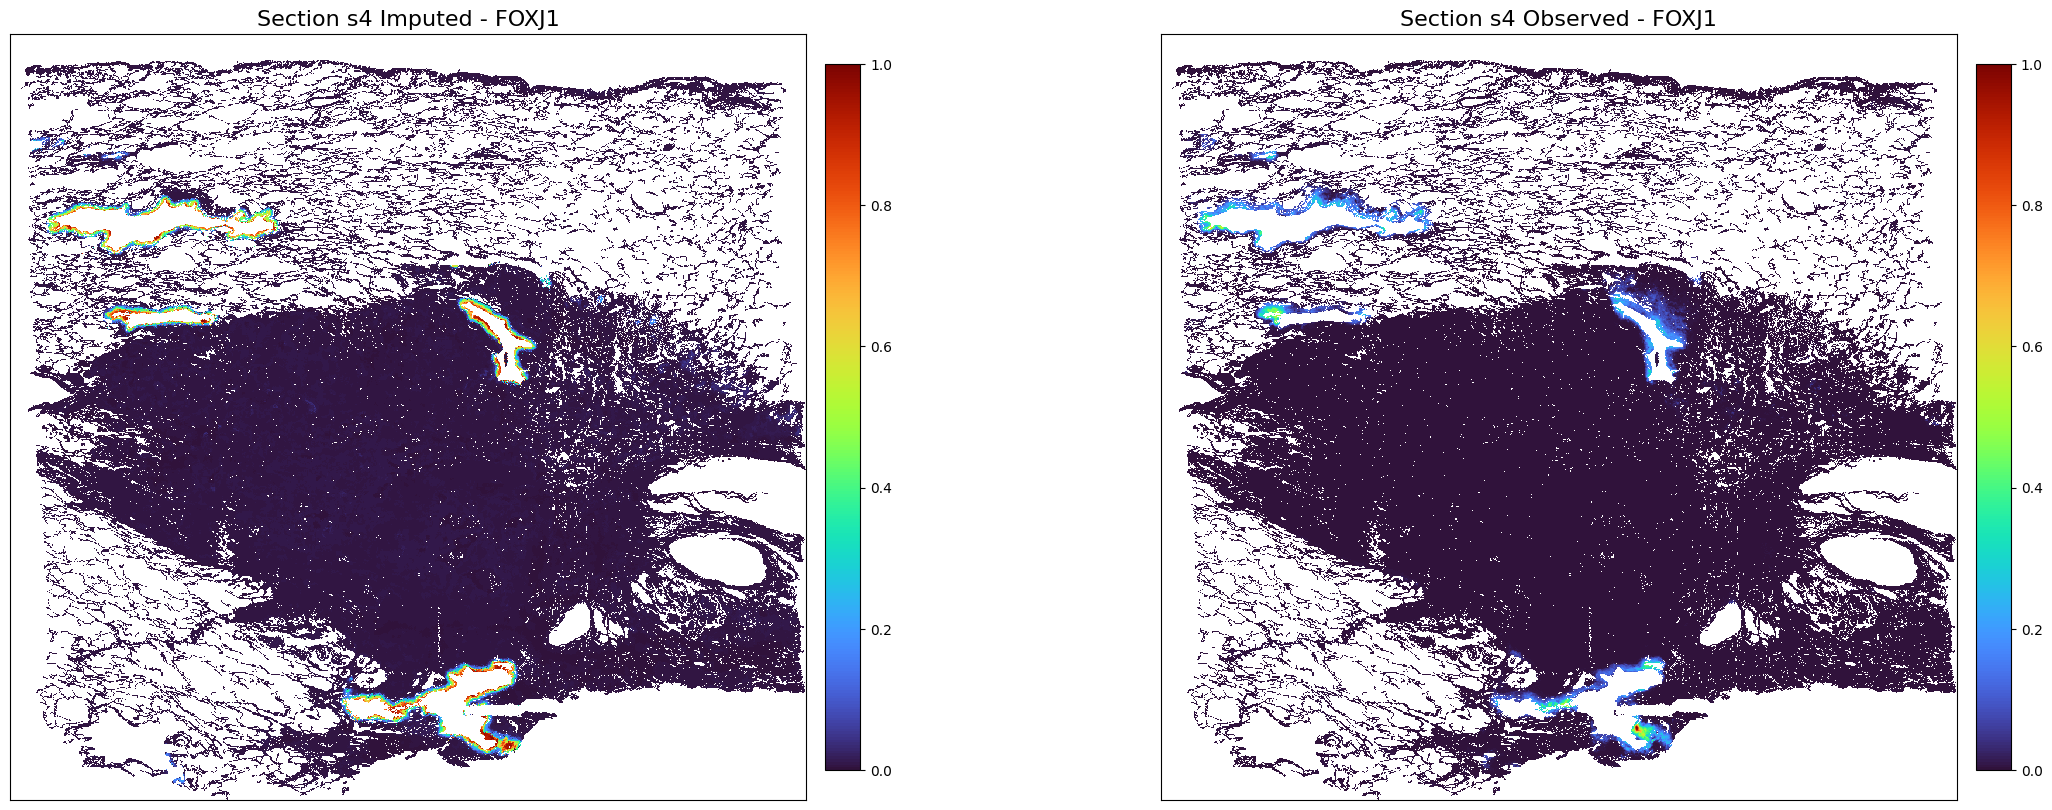

In [85]:
chosed_gene = 'FOXJ1'
plot_marker_comparison_superpixel(chosed_gene, 
                       adata4_gene_imputed_norm, 
                       adata4_rna_norm, 
                       'Section s4 Imputed', 
                       'Section s4 Observed',
                        figscale = 100,)